In [1]:
# 유전 알고리즘을 활용한 머신러닝 입력 최적화 및 대안 제안 메소드
# Part 6. 나도 이제 AI Analyst 실습
# Fast Campus / (주)데이원컴퍼니

# **1. 모듈 설치 및 호출**

In [2]:
!pip install sklearn-genetic-opt
!pip install -U scikit-learn

     |████████████████████████████████| 160 kB 8.4 MB/s 
     |████████████████████████████████| 23.1 MB 66.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn_genetic import GASearchCV
from sklearn_genetic.callbacks import ProgressBar
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn_genetic.plots import plot_search_space
from sklearn_genetic.space import Integer, Continuous
from xgboost import XGBRegressor


pd.set_option('display.max_columns', None)

# **2. 데이터 로드 및 분석**

In [4]:
# collective_asset_data.csv 데이터 파일을 Colab에 업로드
# HTS에서 내려받은 데이터를 가공한 자체 제작 파일
# Chrome 사용시 'incognito'가 아닌 일반 모드 사용

from google.colab import files, drive
file_uploaded = files.upload()

Saving collective_asset_data.csv to collective_asset_data.csv


In [5]:
# Colab에 데이터 파일을 올려놓은 경우
# drive.mount('./content')
! ls /content

collective_asset_data.csv  sample_data


In [6]:
raw_data = pd.read_csv('collective_asset_data.csv')
raw_data.head(5)

,date,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m,STD_yearly_f1m
0,2019-03-04,2190.66,180000.0000,44850.0,-0.554324,733.501875,3245.879189,3146.418003,61.574438,1071.428571,6.029839,-1.773283,812.234572,1300.0,376500.0,0.132979,7229.929114,10497.71228,22003.79875,50.313836,5321.428571,6.823589,-0.528271,5797.628826,3500.0,110500.0,-0.896861,1716.646440,4030.409394,3747.596202,42.696306,3071.428571,4.350540,-1.244000,1616.322988,2000.0,180000.0,0.000000,5070.502934,7523.965280,6728.544689,49.590247,3964.285714,9.947476,0.026547,943.398113,3500.0,0.004814,0.265382
1,2019-03-05,2179.23,180013.1390,44250.0,-1.337793,779.627315,3148.683662,3160.304977,52.014142,1025.000000,6.857710,-2.107706,1038.267788,950.0,382000.0,1.460823,6814.690015,10331.67968,21329.16038,60.732073,5571.428571,6.559895,0.333909,5955.879448,8000.0,109500.0,-0.904977,1748.392118,4105.393211,3769.262095,34.572470,3071.428571,4.901692,-1.714582,1939.071943,2000.0,182000.0,1.111111,4708.702050,7576.753797,6780.794368,59.669029,3857.142857,8.317233,0.728532,1225.765067,4500.0,0.004656,0.234604
2,2019-03-06,2175.60,180026.2789,44000.0,-0.564972,889.592603,3054.692317,3167.420147,42.697869,1017.857143,7.986223,-2.011906,1231.959821,600.0,378000.0,-1.047120,6588.626564,10357.16996,20615.79537,51.352693,5678.571429,5.168388,-0.152974,5499.090834,6500.0,107500.0,-1.826484,1822.601163,4161.307281,3850.051567,30.887108,3035.714286,6.044119,-2.272791,2481.934729,2500.0,177500.0,-2.472527,3671.767286,7582.836218,6740.486443,49.551488,3892.857143,4.755575,-0.487566,1378.404875,5000.0,0.004907,0.218217
3,2019-03-07,2165.79,180039.4198,44450.0,1.022727,1002.780509,2953.008428,3172.387205,45.675260,1032.142857,8.629859,-1.395206,1272.556482,1550.0,375000.0,-0.793651,4902.805319,10256.39482,19841.68394,43.420638,5678.571429,4.272319,-0.695782,4073.082371,7000.0,106000.0,-1.395349,2122.940178,4287.240175,3956.767172,22.142687,2785.714286,7.629736,-2.379384,2749.545417,3000.0,176000.0,-0.845070,2256.102835,7640.864339,6745.717385,36.322949,3428.571429,4.563264,-1.043478,1721.191448,2500.0,0.005018,0.203335
4,2019-03-08,2137.44,180052.5616,43800.0,-1.462317,1055.399806,2785.128242,3180.712120,43.122696,971.428571,9.225378,-1.742379,1327.676542,1000.0,373500.0,-0.400000,4419.488093,10295.29790,19016.51003,45.303062,5785.714286,4.293805,-0.955073,3681.372027,5500.0,103000.0,-2.830189,2532.168043,4506.423468,4113.725298,20.491745,2750.000000,10.009868,-2.671000,3634.900274,3500.0,176000.0,0.000000,2300.000000,7793.035986,6792.881647,45.452599,3214.285714,4.651398,-0.964652,1955.121480,3000.0,0.005033,0.195859


In [7]:
# Data columns
# 
# date: date from 2019-03-04 to 2021-08-20
# 
# Prefix list
# KOSPI: reference KOSPI index
# CASH: time deposits, matuarity 2 years, yield (APY) = 2.7%/y
# SEC: Samsung Electronics (삼성전자, 005930, KOSPI: 전기전자, WICS: 반도체와 반도체장비)
# SBX: Samsung Biologics (삼성바이오로직스, 207940, KOSPI: 의약품, WICS: 제약)
# ORN: Orion (오리온, 271560, KOSPI: 음식료품, WICS: 식품))
# EMT: Emart (이마트, 139480, KOSPI: 유통업, WICS: 백화점과 일반상점)
#
# Suffix list
# close (종가): closing price
# dod_gain (전일대비): day-on-day ratio
# std_1m (과거 한 달 표준편차): price's standard deviation during previous a month
# std_2m (과거 두 달 표준편차): price's standard deviation during previous two months
# std_3m (과거 세 달 표준편차): price's standard deviation during previous three months
# relative_volatility_index (상대 변동성 지수): 일정 기간 동안, 전일 대비 증가한 변동성과 감소한 변동성의 평균을 바탕으로 과변화된 값의 비율로 나타냄
# ATR (평균 True Range): 금일의 고저차, 금일과 전일의 고-저-종가 차이 중 큰 값을 평균낸 값
# BWI (Band Width Indicator): 주가 평균과 주가 사이의 편차
# sigma (): 특정기간 주가의 표준편차와 당일 주가의 차
# standard_deviation: 특정 기간의 변동성
# true_range: 금일의 고저차, 금일과 전일의 고-저-종가 차이 중 큰 값

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           614 non-null    object 
 1   KOSPI                          614 non-null    float64
 2   CASH_close                     614 non-null    float64
 3   SEC_close                      614 non-null    float64
 4   SEC_dod_gain                   614 non-null    float64
 5   SEC_std_1m                     614 non-null    float64
 6   SEC_std_2m                     614 non-null    float64
 7   SEC_std_3m                     614 non-null    float64
 8   SEC_relative_volatility_index  614 non-null    float64
 9   SEC_ATR                        614 non-null    float64
 10  SEC_BWI                        614 non-null    float64
 11  SEC_sigma                      614 non-null    float64
 12  SEC_standard_deviation         614 non-null    flo

In [9]:
df = raw_data.dropna()
df = df.reset_index(drop=True)
df

,date,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m,STD_yearly_f1m
0,2019-03-04,2190.66,180000.0000,44850.0,-0.554324,733.501875,3245.879189,3146.418003,61.574438,1071.428571,6.029839,-1.773283,812.234572,1300.0,376500.0,0.132979,7229.929114,10497.71228,22003.79875,50.313836,5321.428571,6.823589,-0.528271,5797.628826,3500.0,110500.0,-0.896861,1716.646440,4030.409394,3747.596202,42.696306,3071.428571,4.350540,-1.244000,1616.322988,2000.0,180000.0,0.000000,5070.502934,7523.965280,6728.544689,49.590247,3964.285714,9.947476,0.026547,943.398113,3500.0,0.004814,0.265382
1,2019-03-05,2179.23,180013.1390,44250.0,-1.337793,779.627315,3148.683662,3160.304977,52.014142,1025.000000,6.857710,-2.107706,1038.267788,950.0,382000.0,1.460823,6814.690015,10331.67968,21329.16038,60.732073,5571.428571,6.559895,0.333909,5955.879448,8000.0,109500.0,-0.904977,1748.392118,4105.393211,3769.262095,34.572470,3071.428571,4.901692,-1.714582,1939.071943,2000.0,182000.0,1.111111,4708.702050,7576.753797,6780.794368,59.669029,3857.142857,8.317233,0.728532,1225.765067,4500.0,0.004656,0.234604
2,2019-03-06,2175.60,180026.2789,44000.0,-0.564972,889.592603,3054.692317,3167.420147,42.697869,1017.857143,7.986223,-2.011906,1231.959821,600.0,378000.0,-1.047120,6588.626564,10357.16996,20615.79537,51.352693,5678.571429,5.168388,-0.152974,5499.090834,6500.0,107500.0,-1.826484,1822.601163,4161.307281,3850.051567,30.887108,3035.714286,6.044119,-2.272791,2481.934729,2500.0,177500.0,-2.472527,3671.767286,7582.836218,6740.486443,49.551488,3892.857143,4.755575,-0.487566,1378.404875,5000.0,0.004907,0.218217
3,2019-03-07,2165.79,180039.4198,44450.0,1.022727,1002.780509,2953.008428,3172.387205,45.675260,1032.142857,8.629859,-1.395206,1272.556482,1550.0,375000.0,-0.793651,4902.805319,10256.39482,19841.68394,43.420638,5678.571429,4.272319,-0.695782,4073.082371,7000.0,106000.0,-1.395349,2122.940178,4287.240175,3956.767172,22.142687,2785.714286,7.629736,-2.379384,2749.545417,3000.0,176000.0,-0.845070,2256.102835,7640.864339,6745.717385,36.322949,3428.571429,4.563264,-1.043478,1721.191448,2500.0,0.005018,0.203335
4,2019-03-08,2137.44,180052.5616,43800.0,-1.462317,1055.399806,2785.128242,3180.712120,43.122696,971.428571,9.225378,-1.742379,1327.676542,1000.0,373500.0,-0.400000,4419.488093,10295.29790,19016.51003,45.303062,5785.714286,4.293805,-0.955073,3681.372027,5500.0,103000.0,-2.830189,2532.168043,4506.423468,4113.725298,20.491745,2750.000000,10.009868,-2.671000,3634.900274,3500.0,176000.0,0.000000,2300.000000,7793.035986,6792.881647,45.452599,3214.285714,4.651398,-0.964652,1955.121480,3000.0,0.005033,0.195859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2021-08-13,3171.29,192123.4900,74400.0,-3.376623,1440.928520,1177.480548,1149.543919,21.191471,1450.000000,8.819124,-2.720056,2495.515979,2900.0,983000.0,1.131687,23662.417460,35159.43122,35722.24060,60.741261,26785.714290,11.201333,2.343623,30092.523990,24000.0,116500.0,-0.851064,982.344135,1214.134484,1200.476928,28.413075,1571.428571,2.918988,-1.807080,1096.585610,2500.0,175500.0,3.846154,5806.192815,6232.268124,5922.685606,67.109389,4964.285714,13.439148,1.244265,2439.774580,6500.0,0.006487,0.164748
610,2021-08-17,3143.09,192179.5918,74200.0,-0.268817,1843.712288,1459.066712,1369.469773,18.247743,1464

In [10]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           614 non-null    datetime64[ns]
 1   KOSPI                          614 non-null    float64       
 2   CASH_close                     614 non-null    float64       
 3   SEC_close                      614 non-null    float64       
 4   SEC_dod_gain                   614 non-null    float64       
 5   SEC_std_1m                     614 non-null    float64       
 6   SEC_std_2m                     614 non-null    float64       
 7   SEC_std_3m                     614 non-null    float64       
 8   SEC_relative_volatility_index  614 non-null    float64       
 9   SEC_ATR                        614 non-null    float64       
 10  SEC_BWI                        614 non-null    float64       
 11  SEC_sigma          

In [11]:
int_columns = ['SEC_close', 'SEC_true_range',
               'SBX_close', 'SBX_true_range',
               'ORN_close', 'ORN_true_range',
               'EMT_close', 'EMT_true_range'] 
df[int_columns] = df[int_columns].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           614 non-null    datetime64[ns]
 1   KOSPI                          614 non-null    float64       
 2   CASH_close                     614 non-null    float64       
 3   SEC_close                      614 non-null    int32         
 4   SEC_dod_gain                   614 non-null    float64       
 5   SEC_std_1m                     614 non-null    float64       
 6   SEC_std_2m                     614 non-null    float64       
 7   SEC_std_3m                     614 non-null    float64       
 8   SEC_relative_volatility_index  614 non-null    float64       
 9   SEC_ATR                        614 non-null    float64       
 10  SEC_BWI                        614 non-null    float64       
 11  SEC_sigma          

# **3. 다중공선성 확인**

                               CASH_close  SEC_close  SEC_dod_gain  \
CASH_close                            1.0        NaN           NaN   
SEC_close                             NaN        1.0           NaN   
SEC_dod_gain                          NaN        NaN           1.0   
SEC_std_1m                            NaN        NaN           NaN   
SEC_std_2m                            NaN        NaN           NaN   
SEC_std_3m                            NaN        NaN           NaN   
SEC_relative_volatility_index         NaN        NaN           NaN   
SEC_ATR                               NaN        NaN           NaN   
SEC_BWI                               NaN        NaN           NaN   
SEC_sigma                             NaN        NaN           NaN   
SEC_standard_deviation                NaN        NaN           NaN   
SEC_true_range                        NaN        NaN           NaN   
SBX_close                             NaN        NaN           NaN   
SBX_dod_gain        

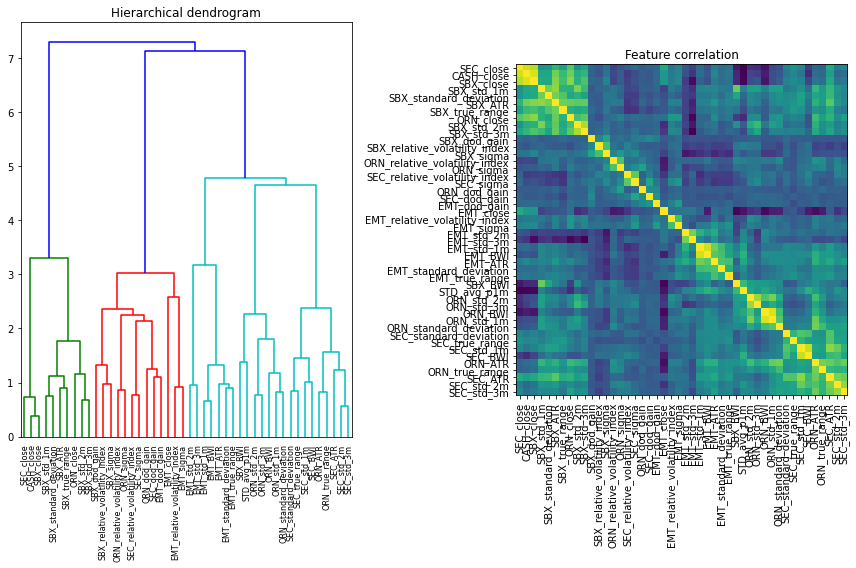

In [12]:
features_cor = list(df)
features_cor.remove('date')
features_cor.remove('STD_yearly_f1m')
features_cor.remove('KOSPI')

x_input = df[features_cor]
cor_table = x_input.corr()
print(cor_table[cor_table > 0.95])
print(cor_table[cor_table < -0.95])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features_cor, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

# **4. 해석 구간 설정**

In [13]:
# Date in data file: 2019-03-04 to 2021-08-20
# Example)
# train_duration = ['2019-07-01', '2019-12-31'] # YYYY-MM-DD format: six months
# test_duration  = ['2020-01-01', '2020-01-31'] # YYYY-MM-DD format: a month

train_duration = ['2020-07-01', '2020-12-31'] # YYYY-MM-DD format: six months
test_duration  = ['2021-01-01', '2021-01-31'] # YYYY-MM-DD format: a month

train_mask = (df['date'] >= train_duration[0]) & (df['date'] <= train_duration[1])
train_data = df.loc[train_mask]

test_mask = (df['date'] >= test_duration[0]) & (df['date'] <= test_duration[1])
test_data = df.loc[test_mask]

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data

,date,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m,STD_yearly_f1m
0,2020-07-01,2106.70,186486.2990,52600,-0.378788,1503.487612,2312.143022,2263.442926,53.470173,1671.428571,10.938923,-0.311809,538.980519,1200,752000,-2.967742,66437.63993,91599.82024,105346.34970,44.071502,38642.85714,31.888415,-0.245899,19679.684960,32000,136500,1.865672,3207.315856,4632.541442,7830.833702,61.411692,5535.714286,8.140489,0.767219,1674.066904,4000,105500,0.000000,4229.657197,3424.810620,3771.436090,48.721262,3500.000000,15.083005,-1.502896,3261.901286,1500,0.005367,0.126479
1,2020-07-02,2135.37,186499.9115,52900,0.570342,1475.262688,2282.308521,2196.489467,60.006356,1528.571429,10.261559,-0.052358,552.177508,800,786000,4.521277,58967.36385,90058.09481,103768.62970,40.256662,34642.85714,28.014836,0.241247,19297.927350,43000,138000,1.098901,3193.352470,4358.728346,7590.225896,60.281333,5214.285714,7.964641,1.128217,1662.077014,5500,107500,1.895735,4308.349452,3547.543997,3658.034271,56.897789,3321.428571,14.765262,-0.942513,3012.059096,2000,0.004193,0.128883
2,2020-07-03,2152.41,186513.5249,53600,1.323251,1432.436735,2271.190779,2159.988329,68.649657,1421.428571,9.612422,0.545267,635.295207,900,771000,-1.908397,52643.23318,89613.77900,102968.71390,30.573788,30285.71429,24.490928,-0.163638,20238.824080,32000,140000,1.449275,3124.399942,4225.077396,7504.455364,67.737230,4750.000000,7.895640,1.575627,1886.796226,4000,107500,0.000000,4217.448873,3483.324771,3646.039477,63.358263,3142.857143,14.341366,-0.857888,2524.381112,2500,0.003092,0.127181
3,2020-07-06,2187.93,186554.3711,55000,2.611940,1320.454467,2259.088986,2137.369857,66.895690,1364.285714,9.128354,1.592309,930.376268,1400,754000,-2.204929,46443.94471,88253.29940,101664.93930,17.705856,29357.14286,20.286604,-0.748770,22990.432790,26000,146500,4.642857,3205.074102,4155.799829,7548.980080,68.009308,5107.142857,9.431581,2.787460,3316.624790,9500,107500,0.000000,4021.504694,3493.471433,3606.296563,58.428138,2964.285714,13.706652,-0.775627,1881.488772,2500,0.003047,0.130004
4,2020-07-07,2164.17,186567.9885,53400,-2.909091,1328.260140,2281.184842,2184.923666,58.730454,1428.571429,8.322697,0.519452,795.989950,2500,751000,-0.397878,38863.73631,87013.75304,100074.91080,19.751004,28928.57143,16.439945,-1.148515,24649.746450,21000,145500,-0.682594,3838.619544,4416.553955,7832.463676,57.217608,5071.428571,10.948172,2.141142,3994.996871,8500,105500,-1.860465,3835.606210,3529.050004,3662.421296,48.083336,2892.857143,12.832179,-1.232856,1738.533865,3000,0.002813,0.127990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2020-12-23,2759.82,188883.6659,73900,2.213001,2528.022943,5634.701694,5638.342934,62.210928,1392.857143,12.992748,0.957404,495.580468,1700,796000,-0.871731,19705.32923,51041.32769,60892.13129,33.107976,24500.00000,8.471813,-0.735979,8879.189152,15000,124500,2.049180,4032.601518,5060.461331,6254.426006,37.841960,4000.000000,11.467994,0.317372,3036.856928,3500,149500,-0.664452,2298.233017,5027.674749,5696.904113,25.606518,3285.714286,6.088947,-1.883127,2030.394050,3000,0.007292,0.415446
121,2020-12-24,2806.86,188897.4534,77800,5.277402,2344.882726,5652.833543,5725.041294,62.172413,1571.428571,13.201096,2.221755,1412.409289,4900,794000,-0.251256,19905.46407,45810.04672,6

# **5. 위험 및 수익률 분석**

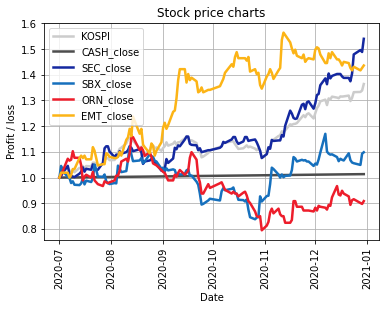

In [14]:
tickers = ['KOSPI', 'CASH_close', 'SEC_close', 'SBX_close', 'ORN_close', 'EMT_close']
color_code = ['0.8', '0.3', '#1428A0', '#1670BD', '#ED1D2B', '#FCB416']

plt.grid()
plt.title('Stock price charts')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Profit / loss')
for idx, ticker in enumerate(tickers):
    train_data[ticker + str('_N')] = train_data[ticker] / train_data[ticker][0]
    plt.plot(train_data['date'], train_data[tickers[idx] + str('_N')],
             label=ticker, c=color_code[idx], alpha=1, linewidth=2.5)
plt.legend()

In [15]:
volatility = []
expected_returns = []

for ticker in tickers:
    dod_value = np.log(train_data[ticker + str('_N')] / train_data[ticker + str('_N')].shift(1))
    dod_value = dod_value.dropna()
    
    if ticker == 'CASH_close':
        volatility.append(0)
    else:
        volatility.append(np.sqrt(dod_value.var()*252))
    expected_returns.append(dod_value.mean()*252)

print(volatility)
print(expected_returns)

[0.1731691082843734, 0, 0.2666883899980539, 0.3689249537139051, 0.36587601414730203, 0.3495653919446356]
[0.6308080594020916, 0.026997470877991814, 0.8773929419520241, 0.19074459106392488, -0.19518426091156701, 0.735422720583808]


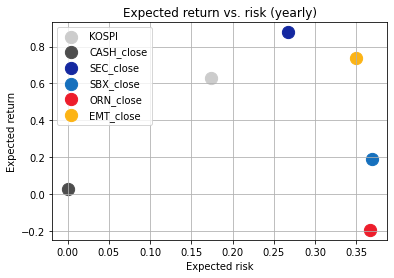

In [16]:
plt.grid()
plt.title('Expected return vs. risk (yearly)')
plt.xlabel('Expected risk')
plt.ylabel('Expected return')

for idx, ticker in enumerate(tickers):
    plt.scatter(volatility[idx], expected_returns[idx],
                label=ticker, c=color_code[idx], s=150)   
plt.legend()

# **6. 최적 포트폴리오 맵 (Markowitz Bullets) 생성 (GA or RS)**

In [17]:
def collective_asset_port(collective_assets, trials=100000):    
    assets = len(collective_assets)
    dod_values = train_data[collective_assets]
    assets_returns = np.log(dod_values / dod_values.shift(1))
    
    weights = []
    volatilities = []
    returns = []
    
    for i in tqdm.tqdm(range(trials)):
        allocated_weights = np.random.dirichlet(np.ones(assets),size=1)        
        allocated_weights = allocated_weights[0]
        
        weights.append(allocated_weights)
        volatilities.append(np.sqrt(np.dot(allocated_weights.T, np.dot(assets_returns.cov() * 252, allocated_weights))))
        returns.append(np.sum(assets_returns.mean() * allocated_weights) * 252)
        
    df = pd.DataFrame(weights, columns=collective_assets)
    df['volatility'] = volatilities
    df['return'] = returns    
    
    plt.figure(figsize=(10, 5))
    plt.grid()    
    plt.scatter(df['volatility'], df['return'], c=(df['return']/df['volatility']), alpha=0.8)
    plt.xlabel('Expected risk')
    plt.ylabel('Expected return')
    plt.colorbar(label='Sharpe ratio (=gain/risk)')

    for idx, ticker in enumerate(tickers):
        plt.scatter(volatility[idx], expected_returns[idx],
                    label=ticker, c=color_code[idx], s=150) 
    plt.legend(loc='upper left') 
    
    return df

100%|██████████| 200000/200000 [03:30<00:00, 951.40it/s]


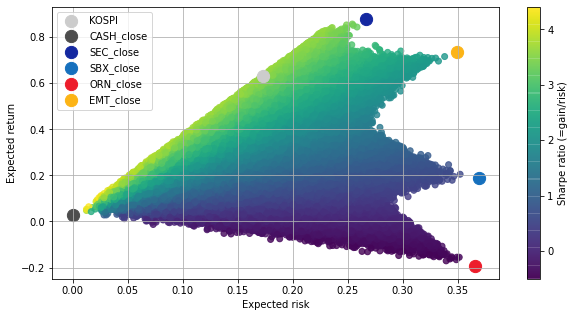

In [18]:
collect_tickers = ['CASH_close_N', 'SEC_close_N', 'SBX_close_N', 'ORN_close_N', 'EMT_close_N']

df_collect = collective_asset_port(collect_tickers, 200000)

# **7. 최적 자산배분 전략**

In [19]:
def portfolio_table(data_table=df_collect):
    data_table['volatility_round'] = data_table['volatility'].round(2)
    data_table['neg_return'] = -data_table['return']

    data_table = data_table.sort_values(by=['volatility_round', 'neg_return'])
    data_table = data_table.drop_duplicates(subset=['volatility_round'])
    data_table = data_table.reset_index(drop=True)

    plt.figure(figsize=(10, 5))
    plt.grid()
    plt.xlim(data_table['volatility_round'].min(), data_table['volatility_round'].max())
    plt.ylim(0, 1)
    plt.title('Optimal allocation of collected assets')
    plt.xlabel('Risk')
    plt.ylabel('Allocation ratio')
    plt.stackplot(data_table['volatility_round'],
                  data_table[collect_tickers[0]],
                  data_table[collect_tickers[1]],
                  data_table[collect_tickers[2]],
                  data_table[collect_tickers[3]],
                  data_table[collect_tickers[4]],
                  colors=color_code[1:],
                  labels=collect_tickers)

    plt.legend(loc='lower left') 

    return data_table

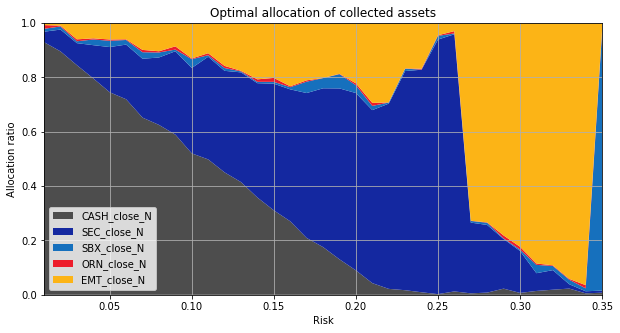

In [20]:
df_collect_port = portfolio_table(df_collect)

# **8. 탐색적 데이터 분석**

In [21]:
y_train = train_data['STD_yearly_f1m']
x_train = train_data.drop(['date', 'STD_yearly_f1m'], axis=1)
x_train = x_train.drop([x for x in x_train.columns if '_N' in x], axis=1)

y_test = test_data['STD_yearly_f1m']
x_test = test_data.drop(['date', 'STD_yearly_f1m'], axis=1)

In [22]:
x_train

,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m
0,2106.70,186486.2990,52600,-0.378788,1503.487612,2312.143022,2263.442926,53.470173,1671.428571,10.938923,-0.311809,538.980519,1200,752000,-2.967742,66437.63993,91599.82024,105346.34970,44.071502,38642.85714,31.888415,-0.245899,19679.684960,32000,136500,1.865672,3207.315856,4632.541442,7830.833702,61.411692,5535.714286,8.140489,0.767219,1674.066904,4000,105500,0.000000,4229.657197,3424.810620,3771.436090,48.721262,3500.000000,15.083005,-1.502896,3261.901286,1500,0.005367
1,2135.37,186499.9115,52900,0.570342,1475.262688,2282.308521,2196.489467,60.006356,1528.571429,10.261559,-0.052358,552.177508,800,786000,4.521277,58967.36385,90058.09481,103768.62970,40.256662,34642.85714,28.014836,0.241247,19297.927350,43000,138000,1.098901,3193.352470,4358.728346,7590.225896,60.281333,5214.285714,7.964641,1.128217,1662.077014,5500,107500,1.895735,4308.349452,3547.543997,3658.034271,56.897789,3321.428571,14.765262,-0.942513,3012.059096,2000,0.004193
2,2152.41,186513.5249,53600,1.323251,1432.436735,2271.190779,2159.988329,68.649657,1421.428571,9.612422,0.545267,635.295207,900,771000,-1.908397,52643.23318,89613.77900,102968.71390,30.573788,30285.71429,24.490928,-0.163638,20238.824080,32000,140000,1.449275,3124.399942,4225.077396,7504.455364,67.737230,4750.000000,7.895640,1.575627,1886.796226,4000,107500,0.000000,4217.448873,3483.324771,3646.039477,63.358263,3142.857143,14.341366,-0.857888,2524.381112,2500,0.003092
3,2187.93,186554.3711,55000,2.611940,1320.454467,2259.088986,2137.369857,66.895690,1364.285714,9.128354,1.592309,930.376268,1400,754000,-2.204929,46443.94471,88253.29940,101664.93930,17.705856,29357.14286,20.286604,-0.748770,22990.432790,26000,146500,4.642857,3205.074102,4155.799829,7548.980080,68.009308,5107.142857,9.431581,2.787460,3316.624790,9500,107500,0.000000,4021.504694,3493.471433,3606.296563,58.428138,2964.285714,13.706652,-0.775627,1881.488772,2500,0.003047
4,2164.17,186567.9885,53400,-2.909091,1328.260140,2281.184842,2184.923666,58.730454,1428.571429,8.322697,0.519452,795.989950,2500,751000,-0.397878,38863.73631,87013.75304,100074.91080,19.751004,28928.57143,16.439945,-1.148515,24649.746450,21000,145500,-0.682594,3838.619544,4416.553955,7832.463676,57.217608,5071.428571,10.948172,2.141142,3994.996871,8500,105500,-1.860465,3835.606210,3529.050004,3662.421296,48.083336,2892.857143,12.832179,-1.232856,1738.533865,3000,0.002813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2759.82,188883.6659,73900,2.213001,2528.022943,5634.701694,5638.342934,62.210928,1392.857143,12.992748,0.957404,495.580468,1700,796000,-0.871731,19705.32923,51041.32769,60892.13129,33.107976,24500.00000,8.471813,-0.735979,8879.189152,15000,124500,2.049180,4032.601518,5060.461331,6254.426006,37.841960,4000.000000,11.467994,0.317372,3036.856928,3500,149500,-0.664452,2298.233017,5027.674749,5696.904113,25.606518,3285.714286,6.088947,-1.883127,2030.394050,3000,0.007292
121,2806.86,188897.4534,77800,5.277402,2344.882726,5652.833543,5725.041294,62.172413,1571.428571,13.201096,2.221755,1412.409289,4900,794000,-0.251256,19905.46407,45810.04672,60913.81517,29.593491,23357.14286,8.594408,-0.816699,9115.371633,14000,125000,0.401606,3938.591119,5074.431129,6087.278402,43.117373,3964.285714,11.062391,0.378

In [23]:
x_test

,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m
0,2944.45,189049.1814,83000,2.469136,2849.894735,5875.820851,6494.264312,77.549599,1942.857143,16.619109,2.557612,3624.375808,4200,829000,0.363196,19619.56931,30431.83155,59613.65807,42.543551,19500.00000,7.950720,0.716003,13991.425950,34000,123000,-0.806452,3412.751822,4459.247688,5751.622465,40.302140,4142.857143,9.487411,-0.411720,2357.965225,3500,151500,0.000000,2752.725922,4238.502311,4778.090956,39.650905,2535.714286,6.092096,-0.601571,1090.871211,1500,0.004359
1,2990.57,189062.9809,83900,1.084337,3290.178567,6055.363255,6786.256802,79.418548,2042.857143,18.330264,2.344898,4075.892540,2300,832000,0.361882,19134.00115,26871.67380,59499.94523,39.731145,19714.28571,7.814924,0.794870,15473.848910,16000,124000,0.813008,3218.209906,4280.922082,5562.826768,39.998469,3964.285714,9.057984,-0.142678,1764.227876,3000,158000,4.290429,2451.912519,4146.126250,4611.193047,39.895246,2785.714286,5.643216,2.106454,2347.871376,8000,0.002965
2,2968.21,189076.7815,82200,-2.026222,3669.669604,6207.902124,7084.309722,63.754592,2121.428571,19.647512,1.653341,3996.110609,2400,817000,-1.802885,19311.33087,25349.17369,59828.57802,41.414624,20500.00000,7.850646,0.039028,15195.064990,21000,124500,0.403226,3153.965758,4267.560913,5348.798738,36.485576,3535.714286,8.664330,-0.040941,1260.952021,3000,155000,-1.898734,2397.394419,4125.990228,4523.817943,39.419119,2928.571429,5.543383,0.896258,2524.381112,6000,0.002883
3,3031.68,189090.5830,82900,0.851582,3852.804174,6291.907685,7301.684616,68.865007,2207.142857,20.988713,1.609439,3752.066097,2000,819000,0.244798,19216.85458,25293.35324,59965.12020,50.928818,19714.28571,5.954515,0.462655,14980.320420,8000,123500,-0.803213,3053.174577,4286.338160,5196.850596,39.342624,3250.000000,8.287205,-0.437016,916.515139,3000,168500,8.709677,2343.074903,4014.844555,4433.630728,51.572550,3750.000000,8.411476,3.588472,5583.233830,14000,0.002895
4,3152.18,189104.3855,88800,7.117008,4082.168541,6352.407067,7514.947570,72.837921,2635.714286,23.624038,2.441275,3892.364320,7100,837000,2.197802,12536.34716,25148.71887,60009.38294,49.603261,19928.57143,5.354490,1.768495,16201.543140,25000,127500,3.238866,2917.511782,4247.020161,5090.553297,45.803223,3428.571429,7.551549,0.858649,1342.572158,6500,179000,6.231454,4124.318125,4316.866469,4790.813569,67.252931,4892.857143,15.486790,3.490181,9321.480569,17500,0.004397
5,3148.45,189145.7991,91000,2.477477,4757.759452,6680.083070,7938.606472,77.934719,3121.428571,28.584783,2.331131,4124.851512,8000,846000,1.075269,13203.31398,24852.13859,60354.52458,60.059144,23500.00000,6.615414,2.091935,16926.015480,59000,122500,-3.921569,2707.743526,4329.732026,5080.578869,37.193112,3535.714286,7.017820,-1.007280,1422.146265,6000,173500,-3.072626,6869.270340,5576.305357,5766.764817,54.153384,5642.857143,18.949299,2.213144,10276.672610,13000,0.004763
6,3125.95,189159.6057,90600,-0.439560,5559.532354,7055.974049,8415.431303,70.192175,3328.571429,30.604080,1.927400,4366.050847,3600,818000,-3.309693,14890.51712,24285.40884,60862.28899,62.684237,26928.57143,6.768044,0.215080,14430.869690,56000,120500,-1.632653,2680.485031,4260.410841,4990.733149,39.950070,3678.571429,7.065894,-1.686455,1702.938637,4500,183000,5.475504,7963.785218,6129.186280,6256.606291,63.022233,6750.000000,23.547763,2.594967,12159.358540,18000,0.006548
7,3148.29,189173.4132,89700,-0.993377,6057.381860,7358.754453,8

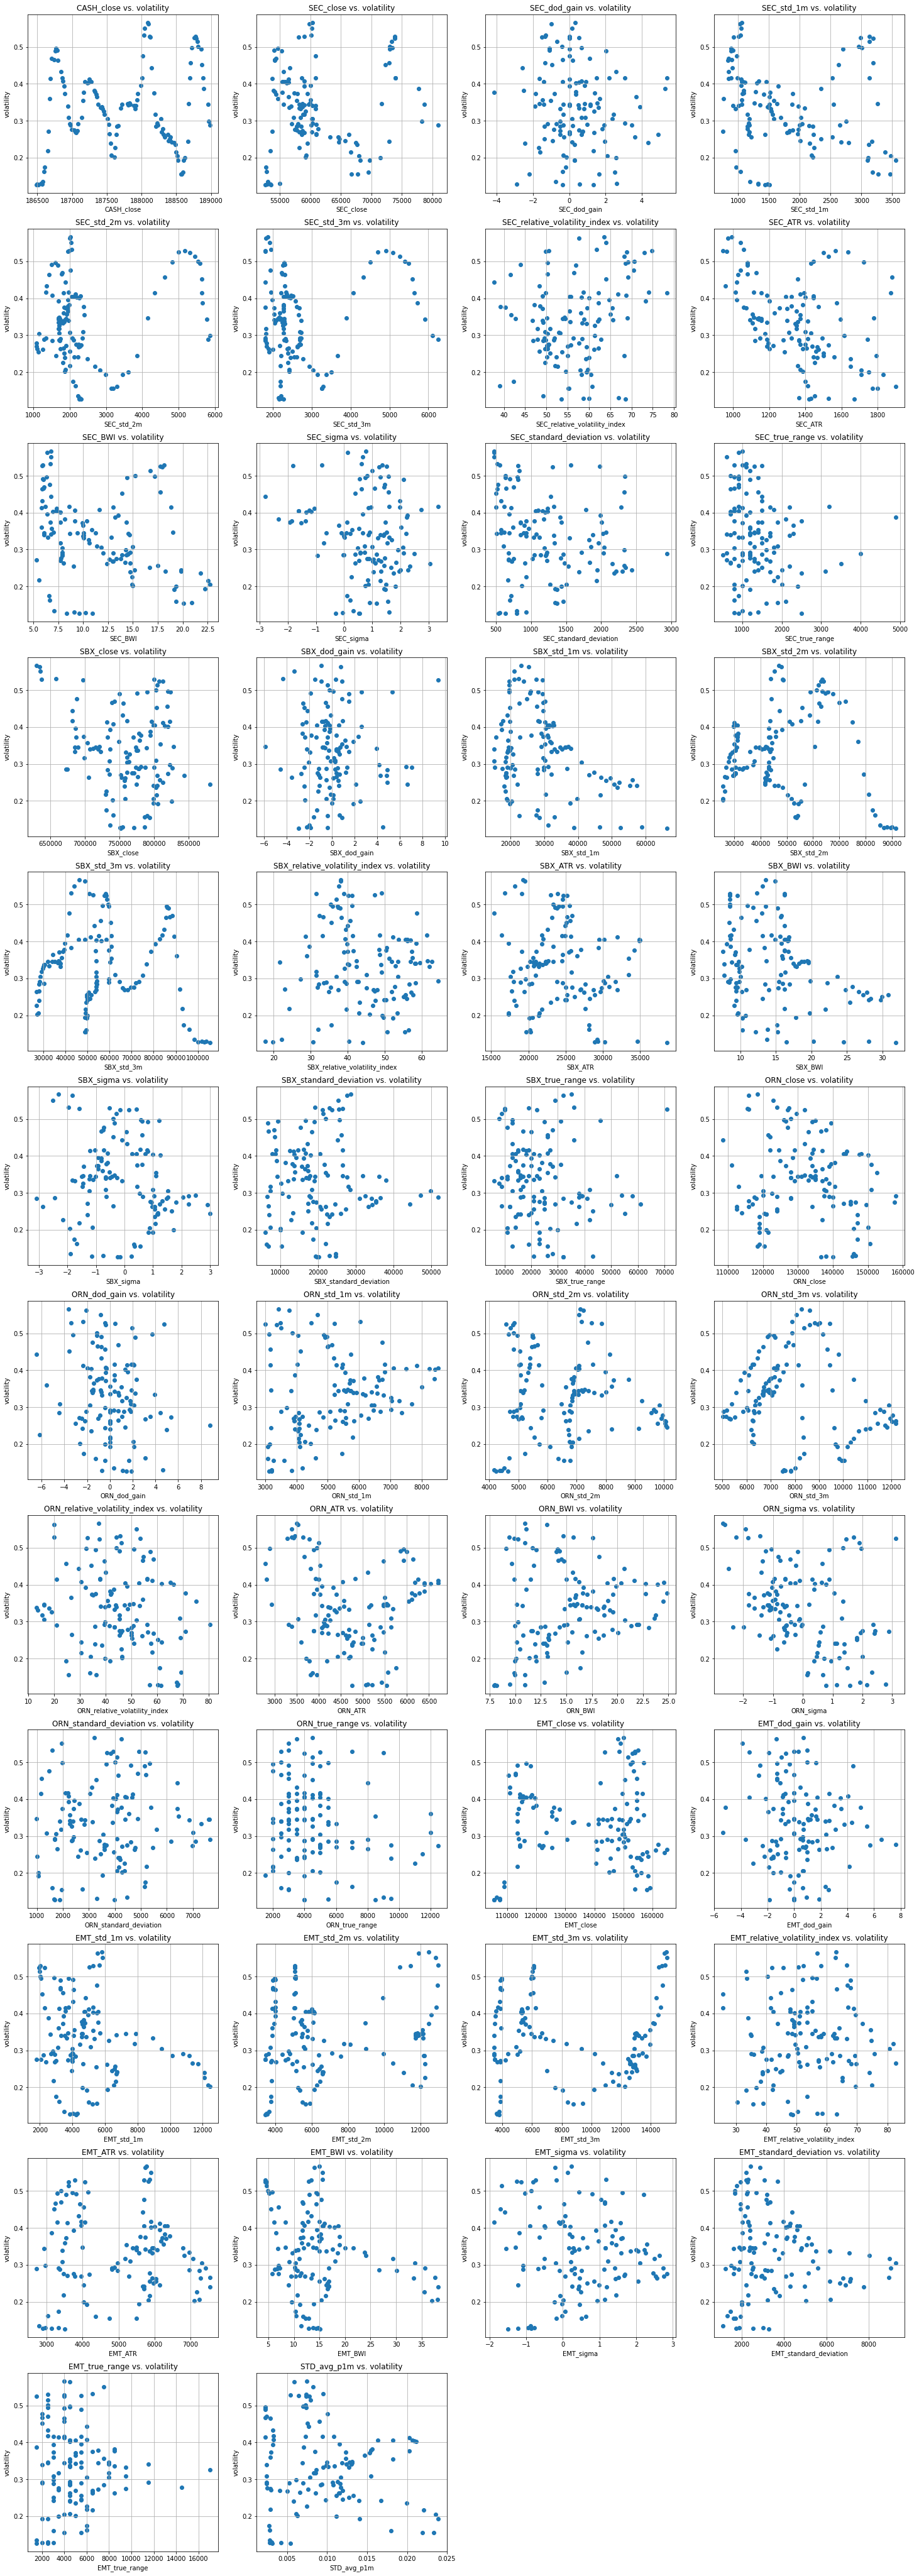

In [24]:
plt.figure(figsize=(25, 250))

for i in range(1, len(x_train.describe().columns)):
    plt.subplot(40, 4, i)
    title = str(x_train.describe().columns[i]) + ' vs. volatility'
    plt.title(title)
    plt.xlabel(x_train.describe().columns[i])
    plt.ylabel('volatility')
    plt.grid()
    plt.scatter(x_train[x_train.describe().columns[i]], y_train)

# **9. 데이터 스케일링**

In [25]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# **10. GA에 의한 최적모델 자동 생성**

  0%|          | 0/301 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-5.60826	3.97567    	-1.57672   	-13.6278   
1  	15    	-1.84414	1.07146    	-1.26491   	-5.02691   
2  	15    	-1.34686	0.132221   	-1.26491   	-1.64021   
3  	18    	-1.291  	0.119526   	-1.19932   	-1.64021   
4  	18    	-1.28642	0.12263    	-1.19932   	-1.64021   
5  	18    	-1.22559	0.0321766  	-1.19932   	-1.26529   
6  	18    	-1.20588	0.0196755  	-1.19932   	-1.26491   
7  	18    	-1.19932	0          	-1.19932   	-1.19932   
8  	17    	-1.19932	0          	-1.19932   	-1.19932   
9  	16    	-1.19932	0          	-1.19932   	-1.19932   
10 	17    	-1.19932	0          	-1.19932   	-1.19932   
11 	18    	-1.19932	0          	-1.19932   	-1.19932   
12 	18    	-1.19932	0          	-1.19932   	-1.19932   
13 	19    	-1.19932	0          	-1.19932   	-1.19932   
14 	19    	-1.22723	0.083715   	-1.19932   	-1.47837   
15 	18    	-1.19932	0          	-1.19932   	-1.19932   
16 	19    	-1.19932	0          	-1.19932   	-1.1

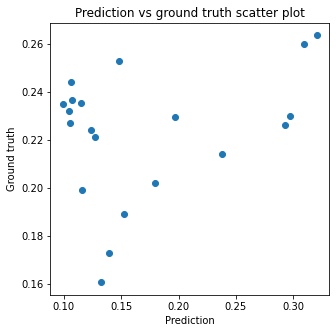

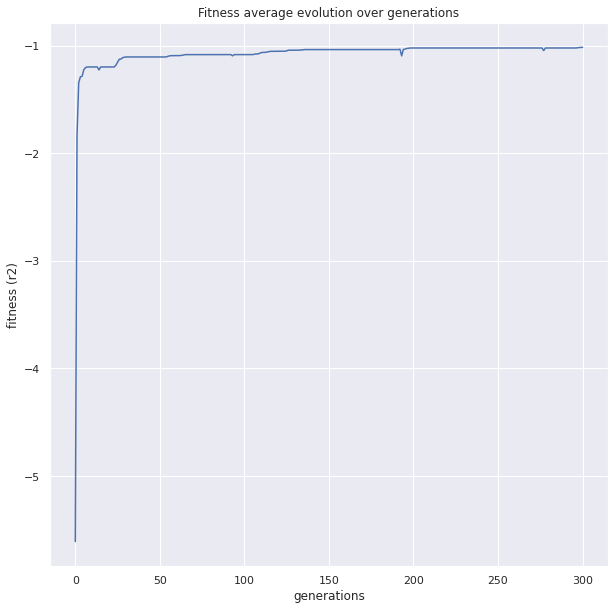

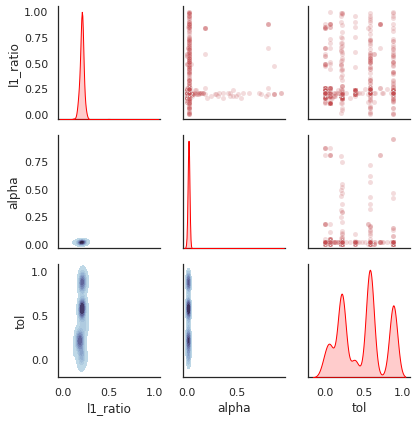

In [26]:
# Elastic Net
en_model = ElasticNet(max_iter=100000000, random_state=42)

en_param = {'l1_ratio': Continuous(0, 1),
            'alpha': Continuous(1e-6, 1e0, distribution='log-uniform'),
            'tol': Continuous(1e-6, 1e0, distribution='log-uniform')}

en_clf = GASearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=True, scoring='r2', generations=300,
                    cv=TimeSeriesSplit())

en_clf.fit(x_train_scaled, y_train, callbacks=ProgressBar())

y_train_pred_en = en_clf.predict(x_train_scaled)
y_test_pred_en = en_clf.predict(x_test_scaled)

print('Best_estimator:', en_clf.best_estimator_)
print('Best_params:', en_clf.best_params_)
print('Best_score:', en_clf.best_score_)
train_score = r2_score(y_train_pred_en, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred_en, y_test)
print('Test  score:', test_score)

plt.figure(figsize=(5, 5))
plt.title('Prediction vs ground truth scatter plot')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred_en, y_test)
plt.grid()
plt.show()

plot_fitness_evolution(en_clf)
plt.show()

plot_search_space(en_clf, features=['l1_ratio', 'alpha', 'tol'])

  0%|          | 0/13 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-2.09092	0.177015   	-1.90811   	-2.44959   
1  	17    	-1.93587	0.0213605  	-1.90811   	-1.98142   
2  	17    	-1.90962	0.0126228  	-1.8915    	-1.92969   
3  	20    	-1.8997 	0.0106282  	-1.8915    	-1.92482   
4  	18    	-1.89299	0.00285458 	-1.8915    	-1.89869   
5  	20    	-1.8915 	2.1065e-16 	-1.8915    	-1.8915    
6  	18    	-1.8915 	1.40433e-16	-1.8915    	-1.8915    
7  	19    	-1.8915 	1.57009e-16	-1.8915    	-1.8915    
8  	17    	-1.8915 	1.85776e-16	-1.8915    	-1.8915    
9  	17    	-1.8915 	1.85776e-16	-1.8915    	-1.8915    
10 	16    	-1.8915 	1.98603e-16	-1.8915    	-1.8915    
11 	17    	-1.8915 	1.71995e-16	-1.8915    	-1.8915    
12 	19    	-1.8915 	1.71995e-16	-1.8915    	-1.8915    
Best_estimator: RandomForestRegressor(max_depth=26, min_samples_split=10, n_estimators=43,
                      n_jobs=-1, random_state=42)
Best_params: {'n_estimators': 43, 'max_depth': 26, 'min_samples_split': 10}

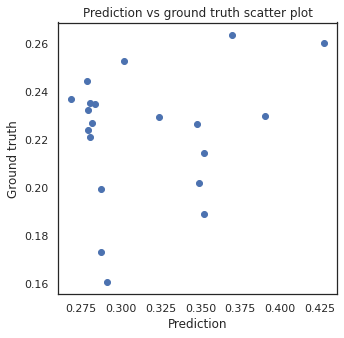

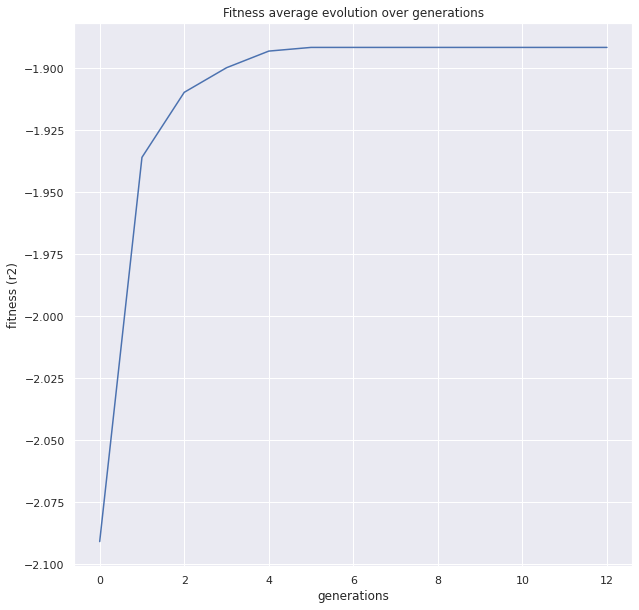

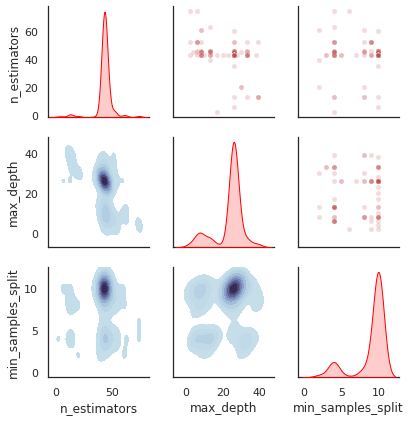

In [27]:
# Random Forest
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

rf_param = {'n_estimators': Integer(2, 80),
            'max_depth': Integer(2, 40),
            'min_samples_split': Integer(2, 10)}

rf_clf = GASearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=True, scoring='r2', generations=12,
                    cv=TimeSeriesSplit())

rf_clf.fit(x_train_scaled, y_train, callbacks=ProgressBar())

y_train_pred_rf = rf_clf.predict(x_train_scaled)
y_test_pred_rf = rf_clf.predict(x_test_scaled)

print('Best_estimator:', rf_clf.best_estimator_)
print('Best_params:', rf_clf.best_params_)
print('Best_score:', rf_clf.best_score_)
train_score = r2_score(y_train_pred_rf, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred_rf, y_test)
print('Test  score:', test_score)

plt.figure(figsize=(5, 5))
plt.title('Prediction vs ground truth scatter plot')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred_rf, y_test)
plt.grid()
plt.show()

plot_fitness_evolution(rf_clf)
plt.show()

plot_search_space(rf_clf, features=['n_estimators', 'max_depth', 'min_samples_split'])

  0%|          | 0/61 [00:00<?, ?it/s]

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	-4.5873	3.74758    	-1.37112   	-13.3062   
1  	20    	-2.15644	0.921754   	-1.21758   	-3.68767   
2  	17    	-1.90429	0.656507   	-1.21758   	-3.02552   
3  	20    	-1.59768	0.485568   	-1.21758   	-2.69148   
4  	20    	-1.47608	0.461532   	-1.19854   	-2.67606   
5  	17    	-1.26465	0.16882    	-1.19854   	-1.77053   
6  	18    	-1.20242	0.0031664  	-1.19854   	-1.205     
7  	17    	-1.19983	0.00258535 	-1.19854   	-1.205     
8  	19    	-1.19672	0.00545583 	-1.18035   	-1.19854   
9  	19    	-1.19672	0.00545583 	-1.18035   	-1.19854   
10 	18    	-1.19308	0.00833392 	-1.18035   	-1.19854   
11 	18    	-1.18399	0.00727444 	-1.18035   	-1.19854   
12 	20    	-1.18035	0          	-1.18035   	-1.18035   
13 	16    	-1.18035	0          	-1.18035   	-1.18035   
14 	17    	-1.18035	0          	-1.18035   	-1.18035   
15 	17    	-1.18035	0          	-1.18035   	-1.18035   
16 	19    	-1.17982	0.00106659 	-1.17769   	-1.180

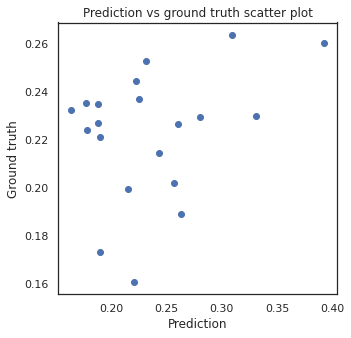

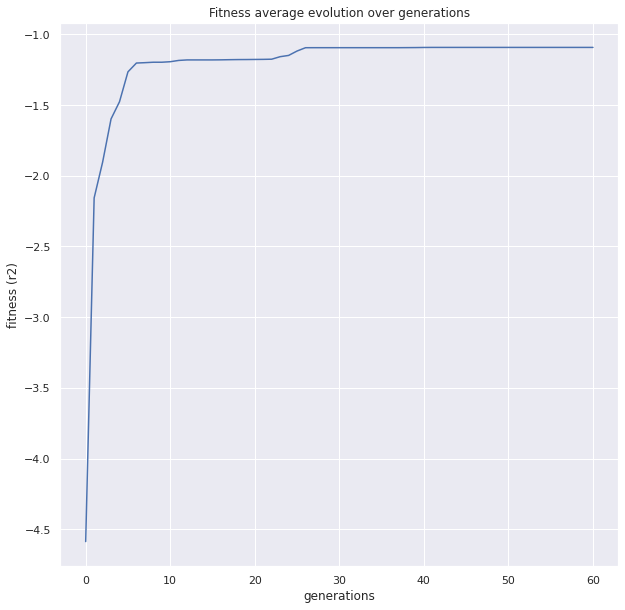

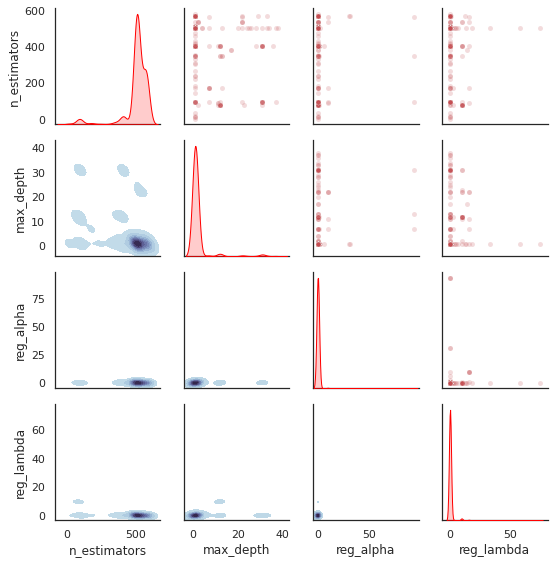

In [28]:
# XGBoost
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

xgb_param = {'n_estimators': Integer(2, 600),
             'max_depth': Integer(1, 40),
             'reg_alpha': Continuous(1e-6, 1e2, distribution='log-uniform'),
             'reg_lambda': Continuous(1e-6, 1e2, distribution='log-uniform')}

xgb_clf = GASearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=True, scoring='r2', generations=60,
                     cv=TimeSeriesSplit())

xgb_clf.fit(x_train_scaled, y_train, callbacks=ProgressBar())

y_train_pred_xgb = xgb_clf.predict(x_train_scaled)
y_test_pred_xgb = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred_xgb, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred_xgb, y_test)
print('Test  score:', test_score)

plt.figure(figsize=(5, 5))
plt.title('Prediction vs ground truth scatter plot')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred_xgb, y_test)
plt.grid()
plt.show()

plot_fitness_evolution(xgb_clf)
plt.show()

plot_search_space(xgb_clf, features=['n_estimators', 'max_depth', 'reg_alpha', 'reg_lambda'])

  0%|          | 0/301 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-1.81237	0.363535   	-1.59656   	-2.56545   
1  	16    	-1.61299	0.0151242  	-1.59637   	-1.63539   
2  	16    	-1.60808	0.0143359  	-1.59637   	-1.63539   
3  	17    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
4  	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
5  	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
6  	18    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
7  	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
8  	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
9  	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
10 	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
11 	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
12 	17    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
13 	19    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
14 	18    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
15 	17    	-1.59637	2.22045e-16	-1.59637   	-1.59637   
16 	17    	-1.59637	2.22045e-16	-1.59637   	-1.5

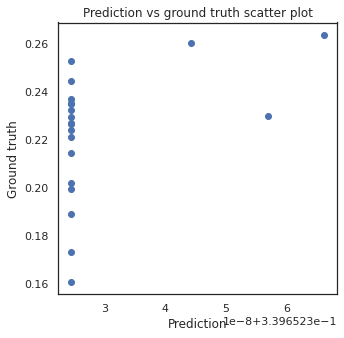

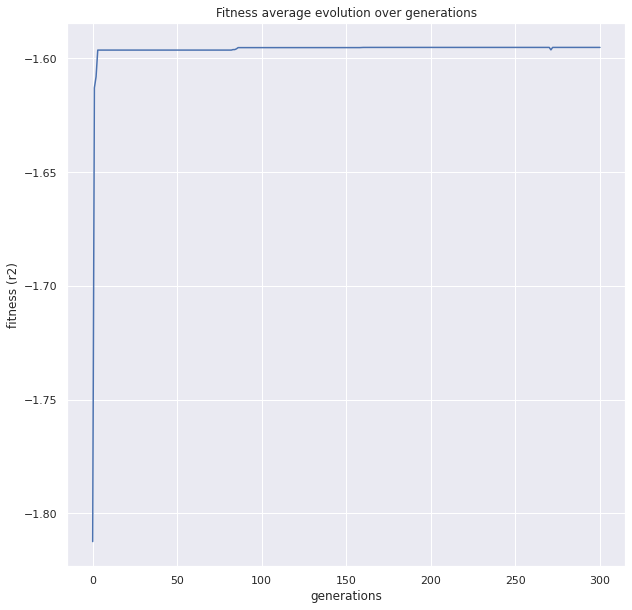

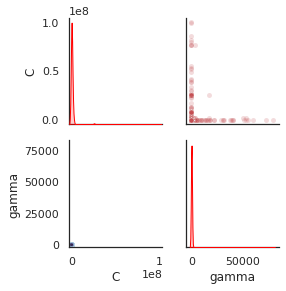

In [29]:
# Support Vector Machine
svr_model = SVR()

svr_param = {'C': Continuous(1e-3, 1e8, distribution='log-uniform'),
             'gamma': Continuous(1e-6, 1e5, distribution='log-uniform')}

svr_clf = GASearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=True, scoring='r2', generations=300,
                     cv=TimeSeriesSplit())

svr_clf.fit(x_train_scaled, y_train, callbacks=ProgressBar())

y_train_pred_svr = svr_clf.predict(x_train_scaled)
y_test_pred_svr = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred_svr, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred_svr, y_test)
print('Test  score:', test_score)

plt.figure(figsize=(5, 5))
plt.title('Prediction vs ground truth scatter plot')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred_svr, y_test)
plt.grid()
plt.show()

plot_fitness_evolution(svr_clf)
plt.show()

plot_search_space(svr_clf, features=['C', 'gamma'])

Train score: 0.573594246114697
Test  score: -1.0275404328521467
Train error (MAE): 0.03695102878874026
Test  error (MAE): 0.046209124978891056
Train std: 0.10922679829039957
Test  std: 0.026817794578798692


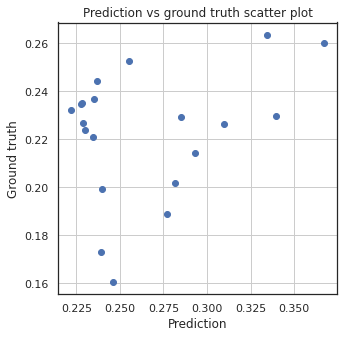

In [30]:
# Voting ensemble
y_train_array = np.stack((y_train_pred_en, y_train_pred_rf, y_train_pred_xgb, y_train_pred_svr))
y_train_pred_ensemble = np.average(y_train_array, axis=0)

y_test_array = np.stack((y_test_pred_en, y_test_pred_rf, y_test_pred_xgb, y_test_pred_svr))
y_test_pred_ensemble = np.average(y_test_array, axis=0)

train_score = r2_score(y_train_pred_ensemble, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred_ensemble, y_test)
print('Test  score:', test_score)

train_score = mean_absolute_error(y_train_pred_ensemble, y_train)
print('Train error (MAE):', train_score)
test_score = mean_absolute_error(y_test_pred_ensemble, y_test)
print('Test  error (MAE):', test_score)

print('Train std:', y_train.std())
print('Test  std:', y_test.std())

plt.figure(figsize=(5, 5))
plt.title('Prediction vs ground truth scatter plot')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred_ensemble, y_test)

In [31]:
y_test_pred_ensemble[0]

0.3346704769318242

In [32]:
df_collect_port

,CASH_close_N,SEC_close_N,SBX_close_N,ORN_close_N,EMT_close_N,volatility,return,volatility_round,neg_return
0,0.929421,0.038569,0.010664,0.013663,0.007683,0.014515,0.063950,0.01,-0.063950
1,0.895632,0.080172,0.011412,0.003240,0.009544,0.023809,0.103085,0.02,-0.103085
2,0.844736,0.081148,0.006859,0.007178,0.060080,0.033762,0.138095,0.03,-0.138095
3,0.796054,0.122350,0.020961,0.004208,0.056427,0.043238,0.173515,0.04,-0.173515
4,0.745172,0.166322,0.023030,0.004832,0.060644,0.054876,0.214096,0.05,-0.214096
5,0.719378,0.201220,0.016975,0.002395,0.060032,0.062548,0.242890,0.06,-0.242890
6,0.651836,0.216619,0.024031,0.008488,0.099026,0.074890,0.283411,0.07,-0.283411
7,0.625092,0.248017,0.018433,0.004497,0.103960,0.082495,0.313578,0.08,-0.313578
8,0.589297,0.306798,0.006057,0.011930,0.085918,0.093232,0.347105,0.09,-0.347105
9,0.520323,0.314246,0.032206,0.002715,0.130511,0.104840,0.391359,0.10,-0.391359


# **11. 최적 배분 자산 예측**

In [33]:
pred_target = y_test_pred_ensemble[0].round(2)

if (pred_target <= df_collect_port['volatility_round'].max()) & (pred_target >= df_collect_port['volatility_round'].min()):
    final_allocation = df_collect_port[df_collect_port['volatility_round'] == y_test_pred_ensemble[0].round(2)]
elif pred_target > df_collect_port['volatility_round'].max():
    final_allocation = df_collect_port[df_collect_port['volatility_round'] == df_collect_port['volatility_round'].max()]
else:
    final_allocation = df_collect_port[df_collect_port['volatility_round'] == df_collect_port['volatility_round'].min()]

final_allocation

,CASH_close_N,SEC_close_N,SBX_close_N,ORN_close_N,EMT_close_N,volatility,return,volatility_round,neg_return
32,0.022921,0.01598,0.016579,0.003101,0.94142,0.329873,0.709538,0.33,-0.709538


CASH_close_N
SEC_close_N
SBX_close_N
ORN_close_N
EMT_close_N


([<matplotlib.patches.Wedge at 0x7f8ee1eb2310>,
 [Text(-0.07914086632088561, 1.097149362337681, 'CASH_close'),
  Text(-0.21230049455540326, 1.0793185350078685, 'SEC_close'),
  Text(-0.3213970242429269, 1.0519999775702429, 'SBX_close'),
  Text(-0.3857803386553139, 1.0301327731447978, 'ORN_close'),
  Text(0.20129733344545345, -1.0814247008219067, 'EMT_close')],
 [Text(-0.0431677452659376, 0.5984451067296441, '2.3%'),
  Text(-0.11580026975749268, 0.5887192009133827, '1.6%'),
  Text(-0.17530746776886919, 0.5738181695837689, '1.7%'),
  Text(-0.21042563926653485, 0.561890603533526, '0.3%'),
  Text(0.10979854551570188, -0.5898680186301308, '94.1%')])

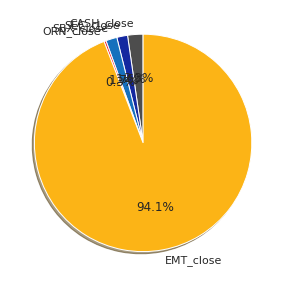

In [34]:
pie_labels = [] 
pie_ratio = []
for i in list(final_allocation)[0:5]:    
    pie_labels.append(i[:-2])
    pie_ratio.append(float(final_allocation[i].values))
plt.figure(figsize=(5, 5))
plt.pie(pie_ratio, labels=pie_labels, shadow=True, startangle=90, colors=color_code[1:], autopct='%1.1f%%')

In [35]:
test_data.head(5)

,date,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m,STD_yearly_f1m
0,2021-01-04,2944.45,189049.1814,83000,2.469136,2849.894735,5875.820851,6494.264312,77.549599,1942.857143,16.619109,2.557612,3624.375808,4200,829000,0.363196,19619.56931,30431.83155,59613.65807,42.543551,19500.00000,7.950720,0.716003,13991.42595,34000,123000,-0.806452,3412.751822,4459.247688,5751.622465,40.302140,4142.857143,9.487411,-0.411720,2357.965225,3500,151500,0.000000,2752.725922,4238.502311,4778.090956,39.650905,2535.714286,6.092096,-0.601571,1090.871211,1500,0.004359,0.263442
1,2021-01-05,2990.57,189062.9809,83900,1.084337,3290.178567,6055.363255,6786.256802,79.418548,2042.857143,18.330264,2.344898,4075.892540,2300,832000,0.361882,19134.00115,26871.67380,59499.94523,39.731145,19714.28571,7.814924,0.794870,15473.84891,16000,124000,0.813008,3218.209906,4280.922082,5562.826768,39.998469,3964.285714,9.057984,-0.142678,1764.227876,3000,158000,4.290429,2451.912519,4146.126250,4611.193047,39.895246,2785.714286,5.643216,2.106454,2347.871376,8000,0.002965,0.259993
2,2021-01-06,2968.21,189076.7815,82200,-2.026222,3669.669604,6207.902124,7084.309722,63.754592,2121.428571,19.647512,1.653341,3996.110609,2400,817000,-1.802885,19311.33087,25349.17369,59828.57802,41.414624,20500.00000,7.850646,0.039028,15195.06499,21000,124500,0.403226,3153.965758,4267.560913,5348.798738,36.485576,3535.714286,8.664330,-0.040941,1260.952021,3000,155000,-1.898734,2397.394419,4125.990228,4523.817943,39.419119,2928.571429,5.543383,0.896258,2524.381112,6000,0.002883,0.229811
3,2021-01-07,3031.68,189090.5830,82900,0.851582,3852.804174,6291.907685,7301.684616,68.865007,2207.142857,20.988713,1.609439,3752.066097,2000,819000,0.244798,19216.85458,25293.35324,59965.12020,50.928818,19714.28571,5.954515,0.462655,14980.32042,8000,123500,-0.803213,3053.174577,4286.338160,5196.850596,39.342624,3250.000000,8.287205,-0.437016,916.515139,3000,168500,8.709677,2343.074903,4014.844555,4433.630728,51.572550,3750.000000,8.411476,3.588472,5583.233830,14000,0.002895,0.226179
4,2021-01-08,3152.18,189104.3855,88800,7.117008,4082.168541,6352.407067,7514.947570,72.837921,2635.714286,23.624038,2.441275,3892.364320,7100,837000,2.197802,12536.34716,25148.71887,60009.38294,49.603261,19928.57143,5.354490,1.768495,16201.54314,25000,127500,3.238866,2917.511782,4247.020161,5090.553297,45.803223,3428.571429,7.551549,0.858649,1342.572158,6500,179000,6.231454,4124.318125,4316.866469,4790.813569,67.252931,4892.857143,15.486790,3.490181,9321.480569,17500,0.004397,0.214041


In [36]:
pie_ratio

[0.022921004056544594,
 0.015979877340856295,
 0.016578581032183945,
 0.0031005841682120324,
 0.9414199534022033]

# **12. 동적 자산 배분 성과 평가**

In [37]:
asset = 10000000 # Total amount of the investment asset

stock_prices = test_data.loc[0][pie_labels]
stock_shares = []

for i in range(len(pie_ratio)):
    stock_shares.append(asset * pie_ratio[i] / stock_prices[i])

stock_shares

[1.212436038432092,
 1.925286426609192,
 0.1999828833797822,
 0.252080013675775,
 62.13993091763718]

In [38]:
investment = np.empty(len(test_data))

for i in range(len(pie_labels)):
    investment += test_data[pie_labels[i]] * stock_shares[i]

test_data['investment_asset'] = investment

In [39]:
test_data

,date,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m,STD_yearly_f1m,investment_asset
0,2021-01-04,2944.45,189049.1814,83000,2.469136,2849.894735,5875.820851,6494.264312,77.549599,1942.857143,16.619109,2.557612,3624.375808,4200,829000,0.363196,19619.56931,30431.83155,59613.65807,42.543551,19500.00000,7.950720,0.716003,13991.425950,34000,123000,-0.806452,3412.751822,4459.247688,5751.622465,40.302140,4142.857143,9.487411,-0.411720,2357.965225,3500,151500,0.000000,2752.725922,4238.502311,4778.090956,39.650905,2535.714286,6.092096,-0.601571,1090.871211,1500,0.004359,0.263442,1.000000e+07
1,2021-01-05,2990.57,189062.9809,83900,1.084337,3290.178567,6055.363255,6786.256802,79.418548,2042.857143,18.330264,2.344898,4075.892540,2300,832000,0.361882,19134.00115,26871.67380,59499.94523,39.731145,19714.28571,7.814924,0.794870,15473.848910,16000,124000,0.813008,3218.209906,4280.922082,5562.826768,39.998469,3964.285714,9.057984,-0.142678,1764.227876,3000,158000,4.290429,2451.912519,4146.126250,4611.193047,39.895246,2785.714286,5.643216,2.106454,2347.871376,8000,0.002965,0.259993,1.040651e+07
2,2021-01-06,2968.21,189076.7815,82200,-2.026222,3669.669604,6207.902124,7084.309722,63.754592,2121.428571,19.647512,1.653341,3996.110609,2400,817000,-1.802885,19311.33087,25349.17369,59828.57802,41.414624,20500.00000,7.850646,0.039028,15195.064990,21000,124500,0.403226,3153.965758,4267.560913,5348.798738,36.485576,3535.714286,8.664330,-0.040941,1260.952021,3000,155000,-1.898734,2397.394419,4125.990228,4523.817943,39.419119,2928.571429,5.543383,0.896258,2524.381112,6000,0.002883,0.229811,1.021396e+07
3,2021-01-07,3031.68,189090.5830,82900,0.851582,3852.804174,6291.907685,7301.684616,68.865007,2207.142857,20.988713,1.609439,3752.066097,2000,819000,0.244798,19216.85458,25293.35324,59965.12020,50.928818,19714.28571,5.954515,0.462655,14980.320420,8000,123500,-0.803213,3053.174577,4286.338160,5196.850596,39.342624,3250.000000,8.287205,-0.437016,916.515139,3000,168500,8.709677,2343.074903,4014.844555,4433.630728,51.572550,3750.000000,8.411476,3.588472,5583.233830,14000,0.002895,0.226179,1.105436e+07
4,2021-01-08,3152.18,189104.3855,88800,7.117008,4082.168541,6352.407067,7514.947570,72.837921,2635.714286,23.624038,2.441275,3892.364320,7100,837000,2.197802,12536.34716,25148.71887,60009.38294,49.603261,19928.57143,5.354490,1.768495,16201.543140,25000,127500,3.238866,2917.511782,4247.020161,5090.553297,45.803223,3428.571429,7.551549,0.858649,1342.572158,6500,179000,6.231454,4124.318125,4316.866469,4790.813569,67.252931,4892.857143,15.486790,3.490181,9321.480569,17500,0.004397,0.214041,1.172282e+07
5,2021-01-11,3148.45,189145.7991,91000,2.477477,4757.759452,6680.083070,7938.606472,77.934719,3121.428571,28.584783,2.331131,4124.851512,8000,846000,1.075269,13203.31398,24852.13859,60354.52458,60.059144,23500.00000,6.615414,2.091935,16926.015480,59000,122500,-3.921569,2707.743526,4329.732026,5080.578869,37.193112,3535.714286,7.017820,-1.007280,1422.146265,6000,173500,-3.072626,6869.270340,5576.305357,5766.764817,54.153384,5642.857143,18.949299,2.213144,10276.672610,13000,0.004763,0.201869,1.138587e+07
6,2021-01-12,3125.95,189159.6057,90600,-0.439560,5559.532354,7055.974049,8415.431303,70.192175,3328.571429,30.604080,1.927400,4366.050847,3600,818000,-3.309693,14890.51712,24285.40884,60862.28899,62.684237,26928.57143,6.768044,0.215080,14430.869690,56000,120500,-1.632653,2680.485031,4260.410841,4990.733

In [40]:
test_data['KOSPI_ref'] = test_data['KOSPI'] / test_data.loc[0]['KOSPI']
test_data['ROI'] = test_data['investment_asset'] / test_data.loc[0]['investment_asset']

In [41]:
test_data

,date,KOSPI,CASH_close,SEC_close,SEC_dod_gain,SEC_std_1m,SEC_std_2m,SEC_std_3m,SEC_relative_volatility_index,SEC_ATR,SEC_BWI,SEC_sigma,SEC_standard_deviation,SEC_true_range,SBX_close,SBX_dod_gain,SBX_std_1m,SBX_std_2m,SBX_std_3m,SBX_relative_volatility_index,SBX_ATR,SBX_BWI,SBX_sigma,SBX_standard_deviation,SBX_true_range,ORN_close,ORN_dod_gain,ORN_std_1m,ORN_std_2m,ORN_std_3m,ORN_relative_volatility_index,ORN_ATR,ORN_BWI,ORN_sigma,ORN_standard_deviation,ORN_true_range,EMT_close,EMT_dod_gain,EMT_std_1m,EMT_std_2m,EMT_std_3m,EMT_relative_volatility_index,EMT_ATR,EMT_BWI,EMT_sigma,EMT_standard_deviation,EMT_true_range,STD_avg_p1m,STD_yearly_f1m,investment_asset,KOSPI_ref,ROI
0,2021-01-04,2944.45,189049.1814,83000,2.469136,2849.894735,5875.820851,6494.264312,77.549599,1942.857143,16.619109,2.557612,3624.375808,4200,829000,0.363196,19619.56931,30431.83155,59613.65807,42.543551,19500.00000,7.950720,0.716003,13991.425950,34000,123000,-0.806452,3412.751822,4459.247688,5751.622465,40.302140,4142.857143,9.487411,-0.411720,2357.965225,3500,151500,0.000000,2752.725922,4238.502311,4778.090956,39.650905,2535.714286,6.092096,-0.601571,1090.871211,1500,0.004359,0.263442,1.000000e+07,1.000000,1.000000
1,2021-01-05,2990.57,189062.9809,83900,1.084337,3290.178567,6055.363255,6786.256802,79.418548,2042.857143,18.330264,2.344898,4075.892540,2300,832000,0.361882,19134.00115,26871.67380,59499.94523,39.731145,19714.28571,7.814924,0.794870,15473.848910,16000,124000,0.813008,3218.209906,4280.922082,5562.826768,39.998469,3964.285714,9.057984,-0.142678,1764.227876,3000,158000,4.290429,2451.912519,4146.126250,4611.193047,39.895246,2785.714286,5.643216,2.106454,2347.871376,8000,0.002965,0.259993,1.040651e+07,1.015663,1.040651
2,2021-01-06,2968.21,189076.7815,82200,-2.026222,3669.669604,6207.902124,7084.309722,63.754592,2121.428571,19.647512,1.653341,3996.110609,2400,817000,-1.802885,19311.33087,25349.17369,59828.57802,41.414624,20500.00000,7.850646,0.039028,15195.064990,21000,124500,0.403226,3153.965758,4267.560913,5348.798738,36.485576,3535.714286,8.664330,-0.040941,1260.952021,3000,155000,-1.898734,2397.394419,4125.990228,4523.817943,39.419119,2928.571429,5.543383,0.896258,2524.381112,6000,0.002883,0.229811,1.021396e+07,1.008069,1.021396
3,2021-01-07,3031.68,189090.5830,82900,0.851582,3852.804174,6291.907685,7301.684616,68.865007,2207.142857,20.988713,1.609439,3752.066097,2000,819000,0.244798,19216.85458,25293.35324,59965.12020,50.928818,19714.28571,5.954515,0.462655,14980.320420,8000,123500,-0.803213,3053.174577,4286.338160,5196.850596,39.342624,3250.000000,8.287205,-0.437016,916.515139,3000,168500,8.709677,2343.074903,4014.844555,4433.630728,51.572550,3750.000000,8.411476,3.588472,5583.233830,14000,0.002895,0.226179,1.105436e+07,1.029625,1.105436
4,2021-01-08,3152.18,189104.3855,88800,7.117008,4082.168541,6352.407067,7514.947570,72.837921,2635.714286,23.624038,2.441275,3892.364320,7100,837000,2.197802,12536.34716,25148.71887,60009.38294,49.603261,19928.57143,5.354490,1.768495,16201.543140,25000,127500,3.238866,2917.511782,4247.020161,5090.553297,45.803223,3428.571429,7.551549,0.858649,1342.572158,6500,179000,6.231454,4124.318125,4316.866469,4790.813569,67.252931,4892.857143,15.486790,3.490181,9321.480569,17500,0.004397,0.214041,1.172282e+07,1.070550,1.172282
5,2021-01-11,3148.45,189145.7991,91000,2.477477,4757.759452,6680.083070,7938.606472,77.934719,3121.428571,28.584783,2.331131,4124.851512,8000,846000,1.075269,13203.31398,24852.13859,60354.52458,60.059144,23500.00000,6.615414,2.091935,16926.015480,59000,122500,-3.921569,2707.743526,4329.732026,5080.578869,37.193112,3535.714286,7.017820,-1.007280,1422.146265,6000,173500,-3.072626,6869.270340,5576.305357,5766.764817,54.153384,5642.857143,18.949299,2.213144,10276.672610,13000,0.004763,0.201869,1.138587e+07,1.069283,1.138587
6,2021-01-12,3125.95,189159.6057,90600,-0.439560,5559.532354,7055.974049,8415.431303,70.192175,3328.571429,30.604080,1.927400,4366.050847,3600,818000,-3.309693,14890.51712,24285.4088

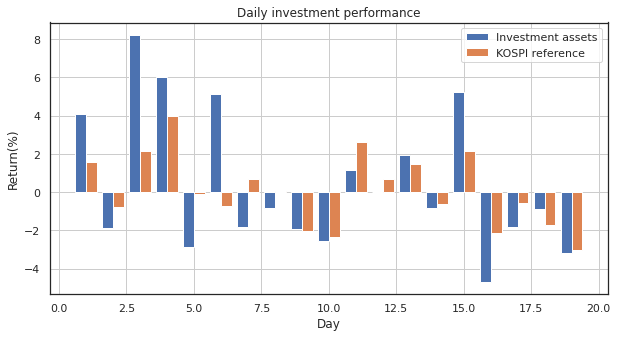

In [47]:
plt.figure(figsize=(10, 5))
plt.title('Daily investment performance')
plt.xlabel('Day')
plt.ylabel('Return(%)')

x = np.arange(len(test_data))
plt.grid()
plt.bar(x - 0.2, (test_data['ROI']/test_data['ROI'].shift(1) - 1)*100, width=0.4, label='Investment assets')
plt.bar(x + 0.2, (test_data['KOSPI_ref']/test_data['KOSPI_ref'].shift(1) - 1)*100, width=0.4, label='KOSPI reference')
plt.legend()

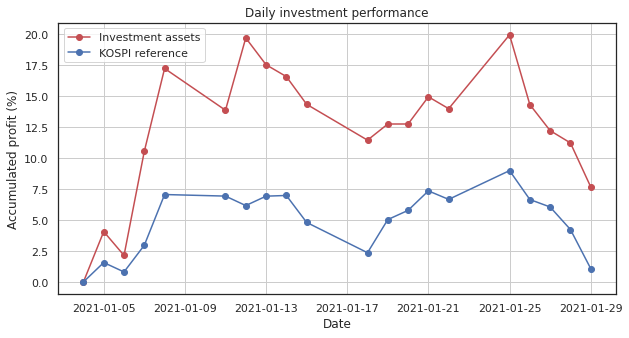

In [49]:
plt.figure(figsize=(10, 5))
plt.title('Daily investment performance')
plt.xlabel('Date')
plt.ylabel('Accumulated profit (%)')

plt.grid()
plt.plot(test_data['date'], (test_data['ROI'] - 1)*100, '-o', label='Investment assets', c='r')
plt.plot(test_data['date'], (test_data['KOSPI_ref'] - 1)*100, '-o', label='KOSPI reference', c='b')
plt.legend()

In [50]:
# Appendix

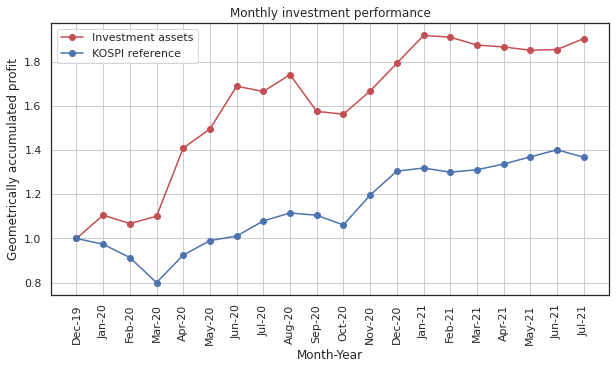

In [51]:
# Training 기간 6개월 + Test 기간 한 달 sliding window로 예측한 결과 및 퍼포먼스 비교

xlabel = ['Dec-19', 'Jan-20', 'Feb-20', 'Mar-20', 'Apr-20',
          'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20',
          'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21',
          'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21']

kospi_perf = [1, 0.9741, 0.91351098, 0.800418321, 0.92488337,
              0.990365112, 1.011063743, 1.079512758, 1.115568484, 1.105193698,
              1.061538547, 1.196353942, 1.30498288, 1.319076695, 1.300213898,
              1.311395738, 1.337099094, 1.369858022, 1.401638728, 1.367999399]

investment_perf = [1, 1.1058, 1.0676499, 1.100960577, 1.409669923,
                   1.495800755, 1.689656533, 1.66566341, 1.741950794, 1.575594493,
                   1.562832178, 1.668010783, 1.793611995, 1.919344196, 1.911858754,
                   1.875915809, 1.867474188, 1.852534395, 1.855683703, 1.905230458]

plt.figure(figsize=(10, 5))
plt.title('Monthly investment performance')
plt.xlabel('Month-Year')
plt.ylabel('Geometrically accumulated profit')
plt.xticks(rotation=90)

plt.grid()
plt.plot(xlabel, investment_perf, '-o', label='Investment assets', c='r')
plt.plot(xlabel, kospi_perf, '-o', label='KOSPI reference', c='b')
plt.legend()